In [1]:
%matplotlib inline


# Repurposing masks into bounding boxes

The following example illustrates the operations available
the `torchvision.ops <ops>` module for repurposing
segmentation masks into object localization annotations for different tasks
(e.g. transforming masks used by instance and panoptic segmentation
methods into bounding boxes used by object detection methods).


In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


ASSETS_DIRECTORY = "../../Talus_224/train/"

plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

## Masks
In tasks like instance and panoptic segmentation, masks are commonly defined, and are defined by this package,
as a multi-dimensional array (e.g. a NumPy array or a PyTorch tensor) with the following shape:

      (num_objects, height, width)

Where num_objects is the number of annotated objects in the image. Each (height, width) object corresponds to exactly
one object. For example, if your input image has the dimensions 224 x 224 and has four annotated objects the shape
of your masks annotation has the following shape:

      (4, 224, 224).

A nice property of masks is that they can be easily repurposed to be used in methods to solve a variety of object
localization tasks.



## Converting Masks to Bounding Boxes
For example, the :func:`~torchvision.ops.masks_to_boxes` operation can be used to
transform masks into bounding boxes that can be
used as input to detection models such as FasterRCNN and RetinaNet.
We will take images and masks from the `PenFudan Dataset <https://www.cis.upenn.edu/~jshi/ped_html/>`_.



In [3]:
from torchvision.io import read_image

img_path = os.path.join(ASSETS_DIRECTORY+"/images/", "20200622_Ortho_rgb_Talus_2mm_3943_1_1_30.png")
mask_path = os.path.join(ASSETS_DIRECTORY+"/labels/", "20200622_Ortho_rgb_Talus_2mm_3943_1_1_30.png")
img = read_image(img_path)
mask = read_image(mask_path)

In [4]:
# We get the unique colors, as these would be the object ids.
obj_ids = torch.unique(mask)
print(mask.shape)
print(obj_ids.shape)
# first id is the background, so remove it.
obj_ids = obj_ids[1:]

# split the color-encoded mask into a set of boolean masks.
masks = mask == obj_ids[:, None, None]
print(masks.shape)

torch.Size([1, 224, 224])
torch.Size([5])
torch.Size([4, 224, 224])


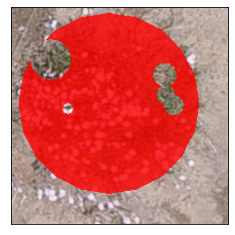

In [5]:
from torchvision.utils import draw_segmentation_masks

drawn_masks = []
areas = []
for mask in masks:
  positive_pixel_count = mask.sum()
  h, w = mask.shape
  area = positive_pixel_count / (w*h)
  areas.append(area)
  drawn_masks.append(draw_segmentation_masks(img, mask, alpha=0.8, colors="red"))

show(drawn_masks[areas.index(max(areas))])


In [6]:
from torchvision.ops import masks_to_boxes

boxes = masks_to_boxes(masks)
boxes = boxes[areas.index(max(areas))]
print(boxes.size())
print(boxes)


torch.Size([4])
tensor([  8.,   7., 192., 192.])


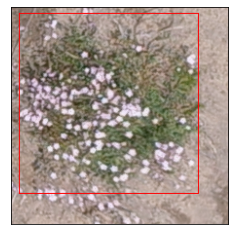

In [7]:
from torchvision.utils import draw_bounding_boxes
import cv2 as cv

box = boxes.unsqueeze(0)
drawn_boxes = draw_bounding_boxes(img, box, colors="red")
show(drawn_boxes)

In [8]:
def intersection_over_union(gt_box, pred_box):
    inter_box_top_left = [max(gt_box[0], pred_box[0]), max(gt_box[1], pred_box[1])]
    inter_box_bottom_right = [min(gt_box[0]+gt_box[2], pred_box[0]+pred_box[2]), min(gt_box[1]+gt_box[3], pred_box[1]+pred_box[3])]

    inter_box_w = inter_box_bottom_right[0] - inter_box_top_left[0]
    inter_box_h = inter_box_bottom_right[1] - inter_box_top_left[1]

    intersection = inter_box_w * inter_box_h
    union = gt_box[2] * gt_box[3] + pred_box[2] * pred_box[3] - intersection
    
    iou = intersection / union

    return iou, intersection, union